In [46]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA 
import statsmodels as sm

In [4]:
df = pd.read_csv('C:\\Users\halln\Desktop\THINKFUL\Datasets\CO2_emission_prediction\emissions.csv')

In [5]:
# Convert to Datetime format
df['Date'] = df['YYYYMM'].apply(lambda x: pd.to_datetime(x, format='%Y%m',errors='coerce'))
# Remove NaT values
df['NaT'] = df['Date'].apply(lambda x: str(x))
df = df[df['NaT']!='NaT']
df = df.drop(columns='NaT')

In [6]:
df.head(n=5)

,MSN,YYYYMM,Value,Column_Order,Description,Unit,Date
0,CLEIEUS,197301,72.076,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-01-01
1,CLEIEUS,197302,64.442,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-02-01
2,CLEIEUS,197303,64.084,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-03-01
3,CLEIEUS,197304,60.842,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-04-01
4,CLEIEUS,197305,61.798,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,1973-05-01


In [7]:
df.dtypes

MSN                     object
YYYYMM                   int64
Value                   object
Column_Order             int64
Description             object
Unit                    object
Date            datetime64[ns]
dtype: object

In [8]:
# Remove entries that are 'Not Available'
df = df[df['Value']!='Not Available']
# Convert data to float 
df['Value'] = df['Value'].apply(lambda x: pd.to_numeric(x))
# Check datatypes 
df.dtypes

MSN                     object
YYYYMM                   int64
Value                  float64
Column_Order             int64
Description             object
Unit                    object
Date            datetime64[ns]
dtype: object

In [9]:
# Add to index?
data = pd.DataFrame(index=df['Date'])
data['Value'] = list(df['Value'])
data['Description'] = list(df['Description'])

In [10]:
data.head(n=5)

,Value,Description
Date,,
1973-01-01,72.076,Coal Electric Power Sector CO2 Emissions
1973-02-01,64.442,Coal Electric Power Sector CO2 Emissions
1973-03-01,64.084,Coal Electric Power Sector CO2 Emissions
1973-04-01,60.842,Coal Electric Power Sector CO2 Emissions
1973-05-01,61.798,Coal Electric Power Sector CO2 Emissions


In [11]:
# Show biggest contributiors to CO2 output
sources = data.groupby('Description').sum()
bar = sources.sort_values(by='Value',ascending=False)
print(bar)

                                                        Value
Description                                                  
Total Energy Electric Power Sector CO2 Emissions    82352.676
Coal Electric Power Sector CO2 Emissions            65782.393
Natural Gas Electric Power Sector CO2 Emissions     11295.359
Petroleum Electric Power Sector CO2 Emissions        4982.993
Residual Fuel Oil Electric Power Sector CO2 Emi...   4239.312
Distillate Fuel, Including Kerosene-Type Jet Fu...    404.887
Petroleum Coke Electric Power Sector CO2 Emissions    338.785
Non-Biomass Waste Electric Power Sector CO2 Emi...    281.367
Geothermal Energy Electric Power Sector CO2 Emi...     10.563


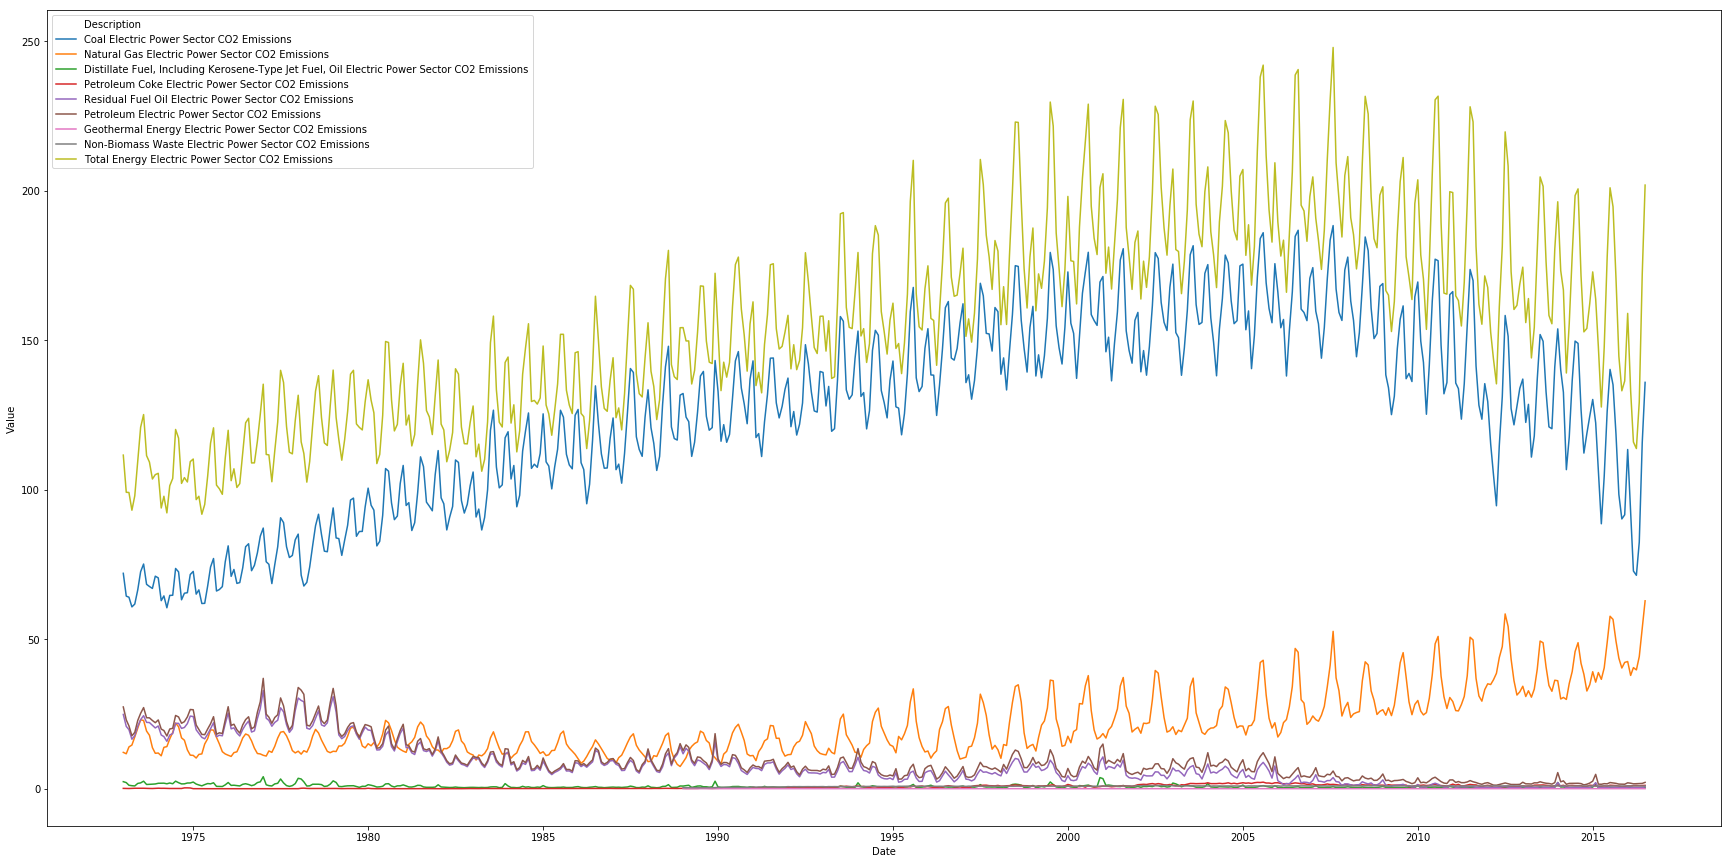

In [12]:
plt.figure(figsize=(30,15))
sns.lineplot(data=data, x=data.index,y='Value',hue='Description')


In [13]:
# Collect top 5 contributors into seperate variables
te = data[data['Description']=='Total Energy Electric Power Sector CO2 Emissions']
ce = data[data['Description']=='Coal Electric Power Sector CO2 Emissions']
ng = data[data['Description']=='Natural Gas Electric Power Sector CO2 Emissions']
pe = data[data['Description']=='Petroleum Electric Power Sector CO2 Emissions']
rf = data[data['Description']=='Residual Fuel Oil Electric Power Sector CO2 Emissions']

In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Determing rolling statistics for timeseries
    rolmean = timeseries.rolling(center=False,window=12).mean()
    rolstd = timeseries.rolling(center=False,window=12).std()

    # Plot rolling statistics alongside data
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of Time Series')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test and print results
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)

In [28]:
te.columns

Index(['Value', 'Description', 'diff_12'], dtype='object')

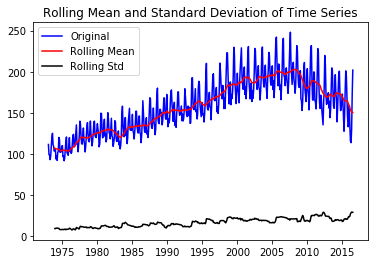

Results of Dickey-Fuller Test:
Test Statistic                  -1.809627
p-value                          0.375693
Number of Lags Used             14.000000
Number of Observations Used    508.000000
Critical Value (1%)             -3.443288
Critical Value (5%)             -2.867246
Critical Value (10%)            -2.569809
dtype: float64


In [27]:
# Data is not yet stationary based on high p value
test_stationarity(te.Value)

In [37]:
te['shift_1'] = te.Value - te.Value.shift(1)

c:\users\halln\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


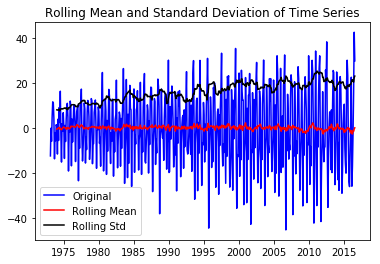

Results of Dickey-Fuller Test:
Test Statistic                -6.610275e+00
p-value                        6.402884e-09
Number of Lags Used            1.300000e+01
Number of Observations Used    5.080000e+02
Critical Value (1%)           -3.443288e+00
Critical Value (5%)           -2.867246e+00
Critical Value (10%)          -2.569809e+00
dtype: float64


In [38]:
test_stationarity(te.shift_1.dropna(inplace=False))

In [39]:
te['seasonal_diff'] = te.Value - te.Value.shift(12)

c:\users\halln\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


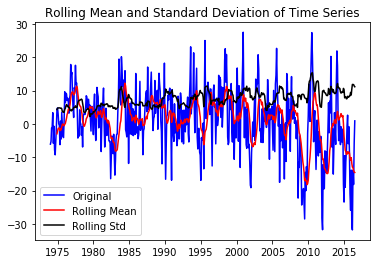

Results of Dickey-Fuller Test:
Test Statistic                  -5.495918
p-value                          0.000002
Number of Lags Used             12.000000
Number of Observations Used    498.000000
Critical Value (1%)             -3.443549
Critical Value (5%)             -2.867361
Critical Value (10%)            -2.569870
dtype: float64


In [40]:
test_stationarity(te.seasonal_diff.dropna(inplace=False))

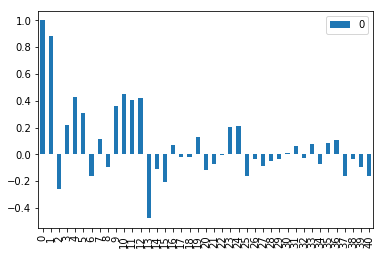

In [41]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(te.Value))
x_acf.plot(kind='bar')

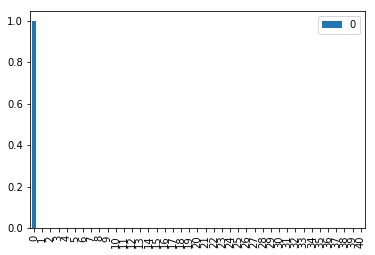

In [42]:
# With seasonal difference plotted pacf shows nothing?
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(te.seasonal_diff))
x_acf.plot(kind='bar')

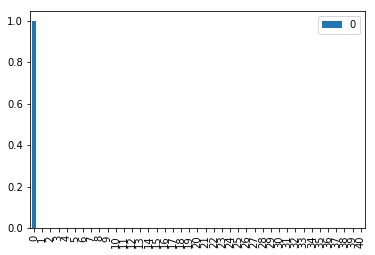

In [43]:
# With shift difference plotted pacf shows nothing?
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(te.shift_1))
x_acf.plot(kind='bar')

In [ ]:
# Look into differencing log values to make data more stationary??
# http://people.duke.edu/~rnau/whatuse.htm

In [ ]:
# RULES for selecting optimal ARIMA parameters
# http://people.duke.edu/~rnau/arimrule.htm

In [ ]:
# Series most likely overdifferenced due to lack of trends in PACF plot?

In [48]:
te['seas_shift'] = te.seasonal_diff - te.seasonal_diff.shift(1)

c:\users\halln\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


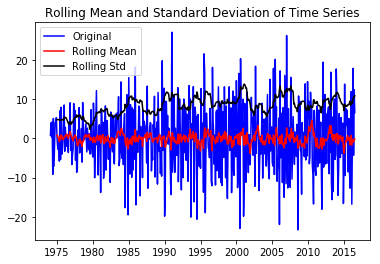

Results of Dickey-Fuller Test:
Test Statistic                -8.574894e+00
p-value                        8.012370e-14
Number of Lags Used            1.400000e+01
Number of Observations Used    4.950000e+02
Critical Value (1%)           -3.443630e+00
Critical Value (5%)           -2.867397e+00
Critical Value (10%)          -2.569889e+00
dtype: float64


In [49]:
# Doing both produces the best p value
test_stationarity(te.seas_shift.dropna(inplace=False))

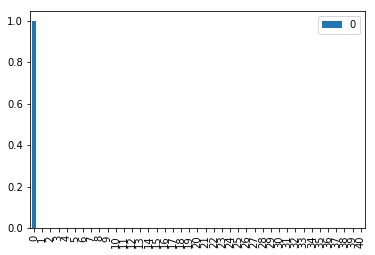

In [50]:
# With shift difference plotted pacf shows nothing?
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(te.seas_shift))
x_acf.plot(kind='bar')